# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

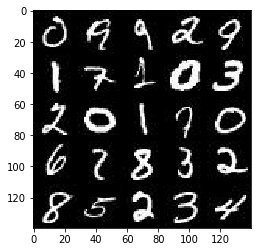

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

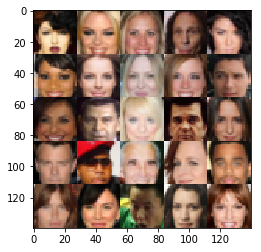

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    return(
        tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="input_images"),
        tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_data"),
        tf.placeholder(dtype=tf.float32, shape=(), name="learning_rate")
    )

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # From theory videos
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        alpha=0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        relu2 = tf.maximum(alpha*x2, x2)
        # 7x7x128
        # Flatten
        flat = tf.reshape(relu2, (-1, 7*7*64))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*128)
        # Convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x128
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x64
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )    
    d_loss = d_loss_real + d_loss_fake
    return(d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #tf.reset_default_graph() # outputs errors WTF?
    #saver  = tf.train.Saver() 
    _, d_w, d_h, d_c = data_shape
    input_real, input_z, lr_placeholder = model_inputs(d_w, d_h, d_c, z_dim)      
    # Losses    
    d_loss, g_loss = model_loss(input_real, input_z, d_c)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0   
    samples = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model                      
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 100 == 0:
                    show_generator_output(sess, 20, input_z, d_c, data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6863... Generator Loss: 0.5498
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 1.0544
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 1.3094... Generator Loss: 0.6900
Epoch 1/2... Discriminator Loss: 1.7706... Generator Loss: 0.2534
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.6364
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.6053
Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.7001
Epoch 1/2... Discriminator Loss: 1.3497... Generator Loss: 0.7454


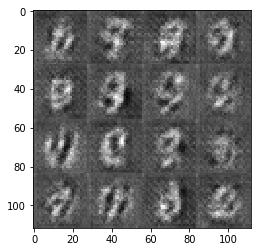

Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.9272
Epoch 1/2... Discriminator Loss: 1.3161... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.6944
Epoch 1/2... Discriminator Loss: 1.3615... Generator Loss: 1.6517
Epoch 1/2... Discriminator Loss: 0.9625... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 1.3931... Generator Loss: 0.5597
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 1.4157
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 1.0092... Generator Loss: 1.7002


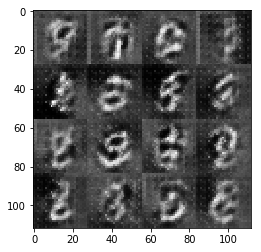

Epoch 1/2... Discriminator Loss: 0.8993... Generator Loss: 1.4278
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.7554
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 2.2766
Epoch 1/2... Discriminator Loss: 0.8009... Generator Loss: 1.8123
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 1.1586
Epoch 1/2... Discriminator Loss: 1.4668... Generator Loss: 0.9009
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 1.0566
Epoch 1/2... Discriminator Loss: 1.1980... Generator Loss: 0.9141
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 0.9583


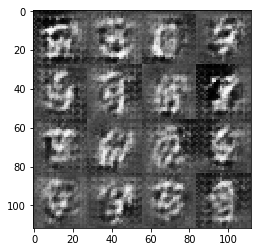

Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 1.1049
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 1.2110
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.2936
Epoch 1/2... Discriminator Loss: 1.2388... Generator Loss: 1.3344
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 1.2407
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 1.4957
Epoch 1/2... Discriminator Loss: 0.8510... Generator Loss: 1.0573
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 0.8573
Epoch 1/2... Discriminator Loss: 0.6355... Generator Loss: 1.5828
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 1.1174


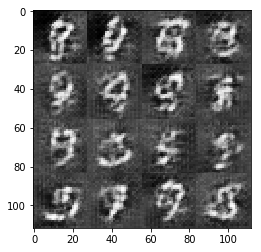

Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 1.4391
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 0.8174
Epoch 1/2... Discriminator Loss: 1.4006... Generator Loss: 0.3613
Epoch 1/2... Discriminator Loss: 1.8620... Generator Loss: 0.1970
Epoch 1/2... Discriminator Loss: 0.7573... Generator Loss: 1.1373
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 1.1996
Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 2.1753
Epoch 1/2... Discriminator Loss: 0.7748... Generator Loss: 2.0551
Epoch 1/2... Discriminator Loss: 1.5110... Generator Loss: 1.2975
Epoch 1/2... Discriminator Loss: 1.0097... Generator Loss: 0.8451


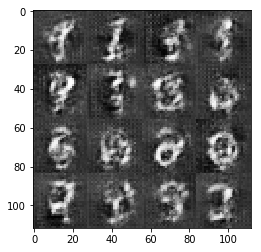

Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.3885... Generator Loss: 0.3497
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 1.4523... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 1.4659... Generator Loss: 0.3089
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.3942
Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 0.5821
Epoch 1/2... Discriminator Loss: 1.0671... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.4582


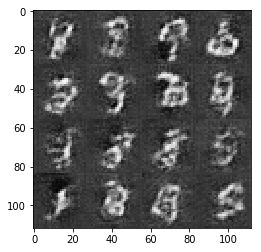

Epoch 2/2... Discriminator Loss: 1.0881... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.3621
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.4090
Epoch 2/2... Discriminator Loss: 1.1696... Generator Loss: 0.4795
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.4972
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.6490
Epoch 2/2... Discriminator Loss: 1.5486... Generator Loss: 0.2857
Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.3402
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 0.4994
Epoch 2/2... Discriminator Loss: 0.6461... Generator Loss: 1.8077


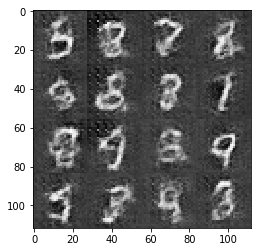

Epoch 2/2... Discriminator Loss: 0.9514... Generator Loss: 1.6449
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.7760
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 2.1289
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 1.1855... Generator Loss: 0.5043
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 1.9979... Generator Loss: 0.1736
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 0.6385
Epoch 2/2... Discriminator Loss: 1.5561... Generator Loss: 0.2824
Epoch 2/2... Discriminator Loss: 1.8068... Generator Loss: 0.2179


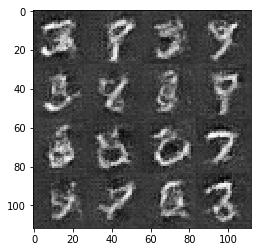

Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.6584... Generator Loss: 0.3035
Epoch 2/2... Discriminator Loss: 1.0333... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 0.8192... Generator Loss: 1.2709
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 1.3995
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.7541
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.8323
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 1.3604
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.3984
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 1.6185


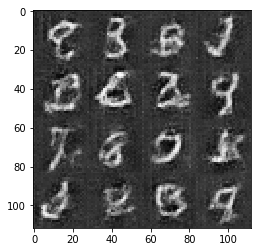

Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 1.4802
Epoch 2/2... Discriminator Loss: 0.6444... Generator Loss: 1.7242
Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 1.0707
Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.4343
Epoch 2/2... Discriminator Loss: 1.5958... Generator Loss: 0.3103
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 0.6498
Epoch 2/2... Discriminator Loss: 0.8530... Generator Loss: 1.4658
Epoch 2/2... Discriminator Loss: 0.8580... Generator Loss: 1.9660
Epoch 2/2... Discriminator Loss: 0.8443... Generator Loss: 1.3714
Epoch 2/2... Discriminator Loss: 0.8428... Generator Loss: 1.5535


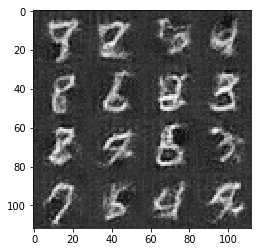

Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 1.6020
Epoch 2/2... Discriminator Loss: 0.8801... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 2.0396
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.1017
Epoch 2/2... Discriminator Loss: 1.0723... Generator Loss: 2.4651
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 1.3469
Epoch 2/2... Discriminator Loss: 2.1112... Generator Loss: 3.3163
Epoch 2/2... Discriminator Loss: 0.8800... Generator Loss: 1.1439
Epoch 2/2... Discriminator Loss: 0.7980... Generator Loss: 1.5932
Epoch 2/2... Discriminator Loss: 0.8138... Generator Loss: 0.8700


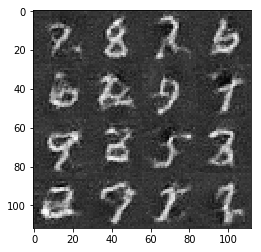

Epoch 2/2... Discriminator Loss: 1.6834... Generator Loss: 0.2542
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 0.8868
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 1.5309
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 1.3000
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 1.8180
Epoch 2/2... Discriminator Loss: 0.6217... Generator Loss: 1.4800
Epoch 2/2... Discriminator Loss: 1.3462... Generator Loss: 0.3873
Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.3148
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 1.2794... Generator Loss: 0.4302


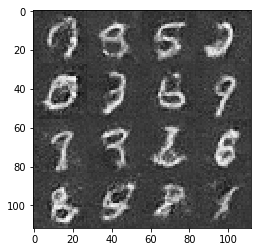

In [16]:
batch_size = 100
z_dim = 250
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 4.0066
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.1069
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 2.1875
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.7571


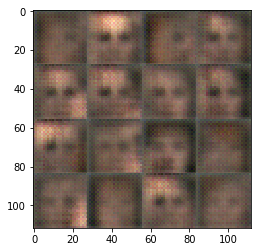

Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 2.1797
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.8753
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.8120... Generator Loss: 0.3355
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.0731... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 1.6414... Generator Loss: 0.3335


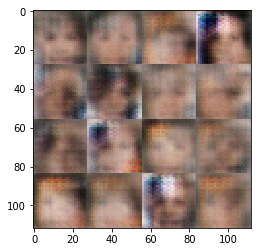

Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.7414
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 2.0331
Epoch 1/1... Discriminator Loss: 1.0798... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.9968
Epoch 1/1... Discriminator Loss: 0.9615... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.0541


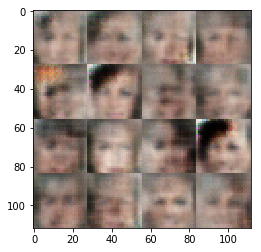

Epoch 1/1... Discriminator Loss: 1.8939... Generator Loss: 0.2165
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 1.6007
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.7470


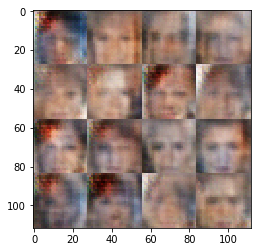

Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.6515
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.6771... Generator Loss: 0.3045
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 2.4642... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.2944


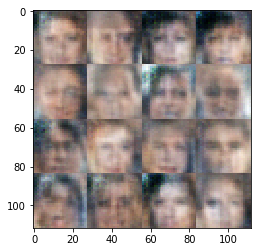

Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.4887
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.2238
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.1573
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.2669
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0607


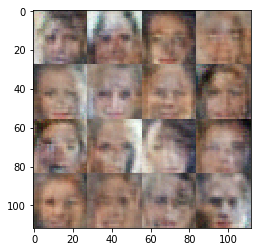

Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.6947


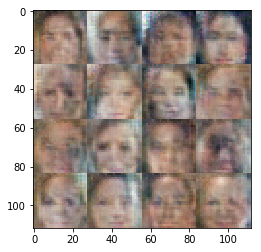

Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.9284
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 1.1577
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.2958
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.1496
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 3.7443
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8870


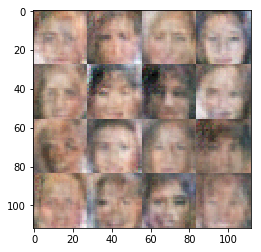

Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 1.3912
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.5008
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.4923
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.2809


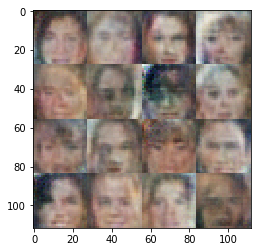

Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 0.9012... Generator Loss: 1.8708


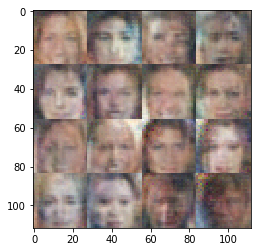

Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.0053... Generator Loss: 1.8968
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.6747... Generator Loss: 0.8014


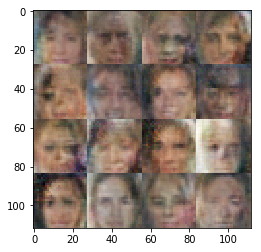

Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.3560
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 2.1566
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.4680


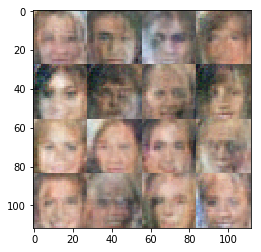

Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.4094


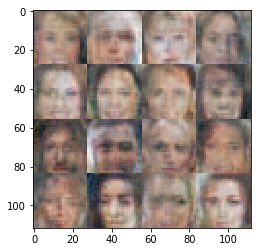

Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 2.0731
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.6810
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 2.0299... Generator Loss: 0.3414
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 1.5600
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.8587
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 3.2591


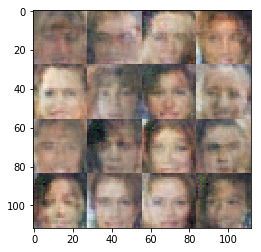

Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.3904
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.0853
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.8200


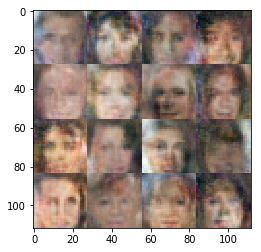

Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.1582
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.7906


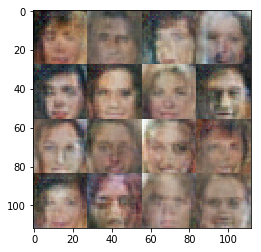

Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.6600
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.3847
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.3730
Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.9154


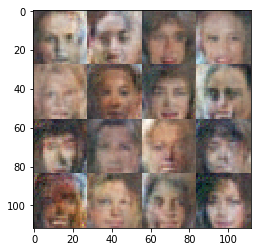

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 2.2185
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 1.5986
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.0646


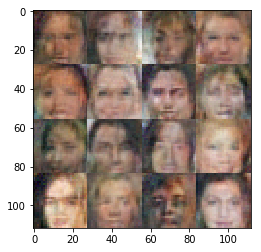

Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.4857
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.5176
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.7415... Generator Loss: 0.2697
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7615


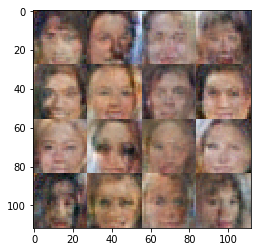

Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 2.0606
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.4530
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 1.0122... Generator Loss: 1.3830
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.6524


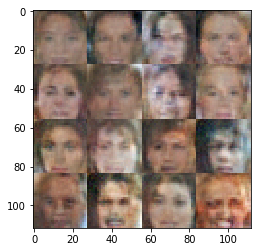

Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.6824


In [17]:
batch_size = 100
z_dim = 250
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.